In [28]:
import pandas as pd
import re
import string

# %pip install nltk

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt

import pickle


In [2]:
def basic_cleaning(texte):
    # stripping:
    data['text'] = data['text'].str.strip()

    # tolower:
    data['text'] = data['text'].str.lower()

    # digit: Remove digits from each row of the ‘text’ column
    data['text'] = data['text'].apply(lambda x: ''.join(char for char in x if not char.isdigit()))

    # punctuation: Remove all punctuation marks from the ‘text’ column
    data['text'] = data['text'].str.replace(r'[{}]'.format(re.escape(string.punctuation)), '', regex=True)

    # delete html-tags
    data['text'] = data['text'].apply(lambda x: re.sub('<[^<]+?>', '', x))

    return data['text']

In [7]:
stop_words = set(stopwords.words('english'))

# Tokenise and remove stop words
def delete_stop_words(text):
    return [word for word in text if word.lower() not in stop_words and word not in string.punctuation]

# apply Lemmatization-Funktion
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Verben lemmatisieren
    verb_lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in text]
    # Nomen lemmatisieren
    return [lemmatizer.lemmatize(word, pos="n") for word in verb_lemmatized]

# NLP-Cleaningfunktion
def nlp_cleaning(texte):
    # Tokenisation
    texte = texte.apply(word_tokenize)
    # Remove stop words
    texte = texte.apply(delete_stop_words)
    # Lemmatisation
    texte = texte.apply(lemmatize_text)
    # Combine words into a string
    return texte.apply(lambda x: ' '.join(x))

In [8]:
# Load the data
data = pd.read_csv('../data/WELFake_Dataset 2.csv')

In [9]:
# Fill missing values with spaces
data = data.fillna(' ')

In [10]:
# Combine 'title' and 'text' columns, then drop 'title' column
data['text'] = data['title'] + ' ' + data['text']
data.drop('title', axis=1, inplace=True)

In [11]:
# Apply basic cleaning and NLP cleaning to the 'text' column
data['text'] = basic_cleaning(data['text'])
data['text'] = nlp_cleaning(data['text'])


In [12]:
# Remove duplicate rows
data.drop_duplicates(inplace=True)

In [13]:
# Shuffle the dataframe to ensure randomness
data = data.sample(frac=1, random_state=42)

In [14]:
# Separate features and labels
X = data['text']
y = data['label']

In [ ]:
# Word count for each entry in the 'text' column
data['word_count'] = data['text'].apply(lambda x: len(x.split()))

In [16]:
data['word_count'].describe()

count    72134.000000
mean       324.460712
std        363.685469
min          1.000000
25%        142.000000
50%        240.000000
75%        399.000000
max      20915.000000
Name: word_count, dtype: float64

In [17]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

# Pad sequences to ensure uniform input length
X_padded = pad_sequences(X_seq, maxlen=500)

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.3, random_state=42)

In [19]:
# Instantiate model
rnn_model_1 = Sequential()
# Add an embedding layer to convert words to dense vectors
rnn_model_1.add(Embedding(input_dim=5000, output_dim=128))
# Add a simple RNN layer
rnn_model_1.add(SimpleRNN(units=128, return_sequences=False))
# Add a dropout layer to prevent overfitting
rnn_model_1.add(Dropout(rate=0.2))
# Add a dense output layer with sigmoid activation for binary classification
rnn_model_1.add(Dense(units=1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary cross-entropy loss
rnn_model_1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Train the model
rnn_model_1.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5


2024-12-12 15:53:02.968161: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


789/789 [==============================] - 167s 211ms/step - loss: 0.3812 - accuracy: 0.8281 - val_loss: 0.3042 - val_accuracy: 0.8804
Epoch 2/5
789/789 [==============================] - 168s 213ms/step - loss: 0.4167 - accuracy: 0.8008 - val_loss: 0.4040 - val_accuracy: 0.8035
Epoch 3/5
789/789 [==============================] - 167s 212ms/step - loss: 0.3781 - accuracy: 0.8266 - val_loss: 0.3524 - val_accuracy: 0.8399
Epoch 4/5
789/789 [==============================] - 168s 213ms/step - loss: 0.2875 - accuracy: 0.8795 - val_loss: 0.2572 - val_accuracy: 0.9014
Epoch 5/5
789/789 [==============================] - 168s 212ms/step - loss: 0.2143 - accuracy: 0.9186 - val_loss: 0.2317 - val_accuracy: 0.9073


In [21]:
# Evaluate the model on the test data
loss, accuracy = rnn_model_1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

677/677 [==============================] - 18s 27ms/step - loss: 0.2317 - accuracy: 0.9073
Test Accuracy: 0.91


In [22]:
# Generate predictions
y_pred_prob = rnn_model_1.predict(X_test)
# Convert probabs to 0 or 1
y_pred = (y_pred_prob > 0.5).astype(int)

677/677 [==============================] - 19s 27ms/step


In [24]:
# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print performance metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90     10442
           1       0.91      0.91      0.91     11199

    accuracy                           0.91     21641
   macro avg       0.91      0.91      0.91     21641
weighted avg       0.91      0.91      0.91     21641



In [25]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

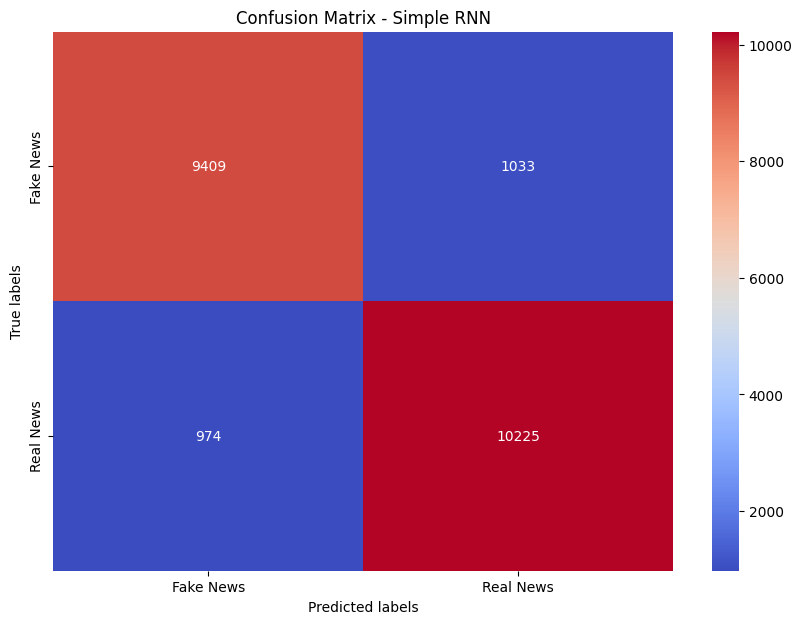

In [26]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=True)

# Set axis labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Simple RNN')

# Set custom tick labels
ax.xaxis.set_ticklabels(['Fake News', 'Real News'])
ax.yaxis.set_ticklabels(['Fake News', 'Real News'])

# Show the plot
plt.show()

In [27]:
# Save the model to a file
with open('trained_rnn_model_1.pkl', 'wb') as file:
    pickle.dump(rnn_model_1, file)

INFO:tensorflow:Assets written to: ram://4ae3392e-6d41-41ec-8198-6c211d23482a/assets


In [ ]:

# Instantiate the LSTM model
lstm_model = Sequential()

# Add an embedding layer
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=500))

# Add the LSTM layer
lstm_model.add(LSTM(units=128, return_sequences=False))

# Add a dropout layer to prevent overfitting
lstm_model.add(Dropout(rate=0.2))

# Add the dense output layer
lstm_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary cross-entropy loss
lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [32]:
# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/5
789/789 [==============================] - 385s 486ms/step - loss: 0.2237 - accuracy: 0.9156 - val_loss: 0.1565 - val_accuracy: 0.9466
Epoch 2/5
789/789 [==============================] - 371s 470ms/step - loss: 0.1697 - accuracy: 0.9373 - val_loss: 0.2114 - val_accuracy: 0.9214
Epoch 3/5
789/789 [==============================] - 373s 473ms/step - loss: 0.2641 - accuracy: 0.8917 - val_loss: 0.2506 - val_accuracy: 0.9043
Epoch 4/5
789/789 [==============================] - 450s 570ms/step - loss: 0.1604 - accuracy: 0.9415 - val_loss: 0.1227 - val_accuracy: 0.9543
Epoch 5/5
789/789 [==============================] - 492s 623ms/step - loss: 0.0949 - accuracy: 0.9667 - val_loss: 0.1100 - val_accuracy: 0.9593


In [ ]:
# Evaluate the LSTM model
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


677/677 [==============================] - 65s 96ms/step - loss: 0.1100 - accuracy: 0.9593
Test Accuracy: 0.96


In [35]:
# Generate predictions
y_pred_prob = lstm_model.predict(X_test)

# Convert probabilities to 0 or 1
y_pred = (y_pred_prob > 0.5).astype(int)

677/677 [==============================] - 63s 93ms/step


In [ ]:
# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print performance metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.96
Precision: 0.98
Recall: 0.94
F1 Score: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     10442
           1       0.98      0.94      0.96     11199

    accuracy                           0.96     21641
   macro avg       0.96      0.96      0.96     21641
weighted avg       0.96      0.96      0.96     21641



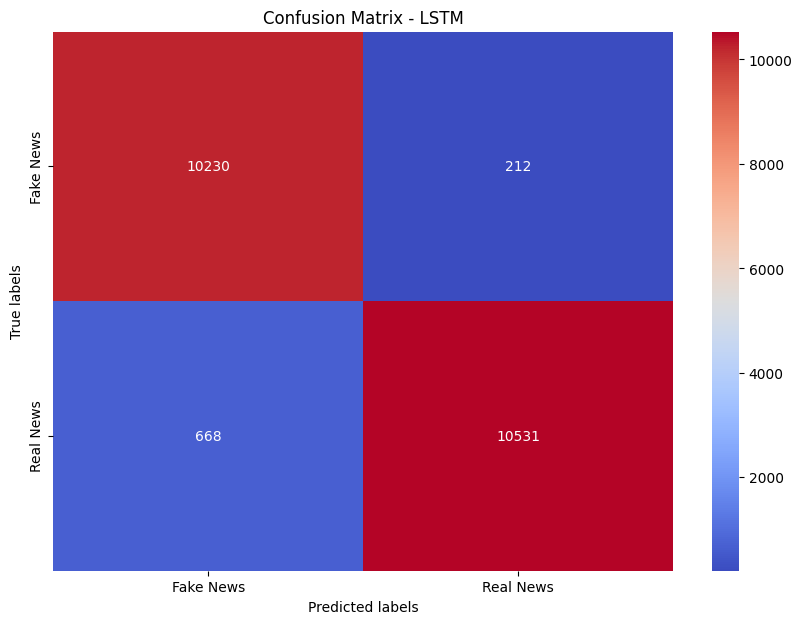

In [37]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=True)

# Set axis labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - LSTM')

# Set custom tick labels
ax.xaxis.set_ticklabels(['Fake News', 'Real News'])
ax.yaxis.set_ticklabels(['Fake News', 'Real News'])

# Show the plot
plt.show()